## Generative Adversarial Networks

Training GAN on data distribution is a gaussian distribution using MLP and momentum optimizer

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import tensorflow as tf
from scipy.stats import norm

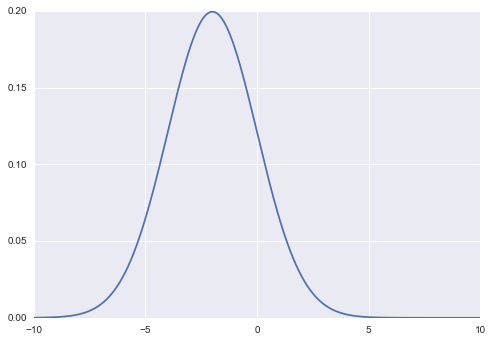

In [2]:
mu, sigma = -2, 2
xs = np.linspace(-10,10,4000)
plt.plot(xs, norm.pdf(xs,loc = mu, scale = sigma))

In [3]:
maxIter  = 1000
M = 200 # minibatch size

In [4]:
# Multi Layer Perceptron

def mlp(input_data, output_dim):
    
    """
    Multi Layer Perceptron that will be used for Generative and Discriminative model
    
    Args:
        input_data: Data or Activations coming into the network
        output_dim: dimension of the data going out of the network
    Output:
        fc3: Fully connected output
    """
    
    w1 = tf.get_variable("w0", [input_data.get_shape()[1], 6], initializer = tf.random_normal_initializer())
    b1 = tf.get_variable("b0", [6], initializer = tf.constant_initializer(0.0))
    w2 = tf.get_variable("w1", [6,5], initializer= tf.random_normal_initializer())
    b2 = tf.get_variable("b1", [5], initializer= tf.constant_initializer(0.0))
    w3 = tf.get_variable("w2", [5,output_dim], initializer= tf.random_normal_initializer())
    b3 = tf.get_variable("b2", [output_dim], initializer= tf.constant_initializer(0.0))
    
    fc1 = tf.nn.tanh(tf.matmul(input_data,w1) + b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1,w2) + b2)
    fc3 = tf.nn.tanh(tf.matmul(fc2,w3) + b3)
    
    weights = [w1,b1,w2,b2,w3,b3]
    return fc3, weights

In [5]:
def momentum_optimizer(loss, var_list):
    """
    Momentum optimizer
    
    Args:
        loss: loss function value
        var_list: list of variables involved in optimization process
    Output:
        optimizer: optimization function
    """
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.001, batch, maxIter//4, 0.95, staircase = True) #learning rate decay
    optimizer = tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list = var_list)
    
    return optimizer
    
    

# Pre-Decision Surface 

Before learning to discriminate between original data and generated data the decision surface is arbitrary

In [6]:
with tf.variable_scope("D_pre"):
    X = tf.placeholder(tf.float32,shape=(M,1))
    Y = tf.placeholder(tf.float32,shape=(M,1))
    D, theta = mlp(X, 1)
    loss = tf.reduce_mean(tf.square(D - Y))

In [7]:
optimizer = momentum_optimizer(loss, None)

In [10]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10adb3950>> ignored


In [11]:
# plot decision surface
def plot_d0(D, input_data):
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-10,10,1000)
    ax.plot(xs, norm.pdf(xs,loc = mu,scale = sigma), label = 'p_data')
    # decisionsurface
    r = 1000
    xs = np.linspace(-10,10,r)
    ds = np.zeros((r,1))
    # process multiple points in parallel in a minibatch
    for i in range(r/M):
        x = np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)] = sess.run(D, {X: x})
        
    ax.plot(xs, ds, label='decision surface')
    ax.set_ylim(0,1.1)
    plt.legend()

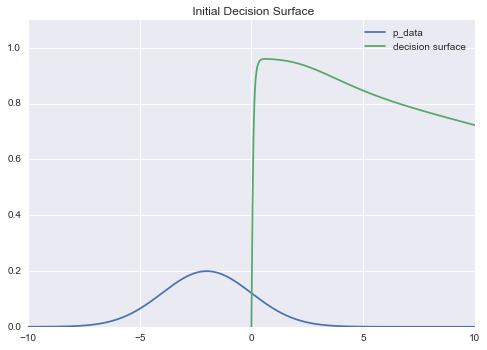

In [12]:
plot_d0(D, X)
plt.title(" Initial Decision Surface")

In [14]:
lh = np.zeros(1000)
for i in range(1000):
    d = (np.random.random(M) - 0.5) * 10.0
    labels = norm.pdf(d, loc=mu, scale=sigma)
    lh[i],_ = sess.run([loss, optimizer], {X: np.reshape(d, (M,1)), Y: np.reshape(labels,(M,1))})

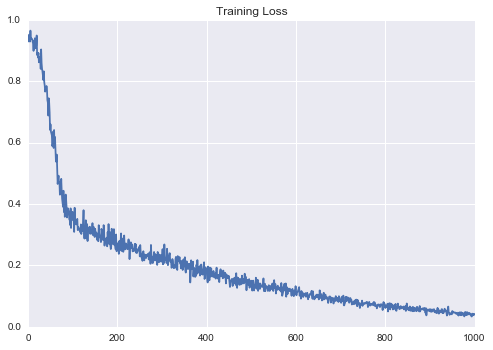

In [16]:
plt.plot(lh)
plt.title("Training Loss")

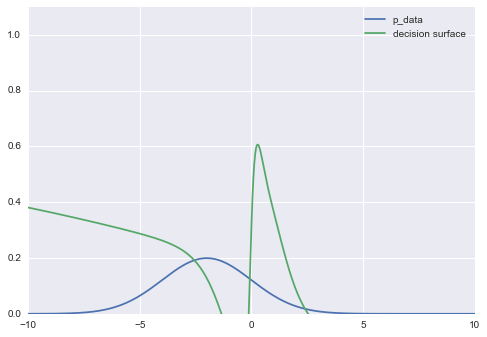

In [17]:
plot_d0(D, X)

In [22]:
# copy the learned weights over into a temporary array
D_weights = sess.run(theta)
sess.close()     # closing D_pre session

RuntimeError: Attempted to use a closed Session.

# Main Network ( Disicriminator and Generator)

Generator - Scope "G"
Discriminator - Scope "D"

In [21]:
with tf.variable_scope("G"):
    Z = tf.placeholder(tf.float32, shape=(M,1))
    G, g_theta = mlp(Z, 1)
    G = tf.mul(5.0, G)    # scaling up to match range
    
with tf.variable_scope("D") as var_scope:
    
    X = tf.placeholder(tf.float32, shape=(M,1))
    out1, d_theta = mlp(X, 1) # likelihood of X belonging to the data distribution
    D1 = tf.maximum(tf.minimum(out1, 0.999), 0.001) # converting into probabilities by clamping it at 0999 and 0.001
    
    ## need to keep a copy of D which takes in G(X) as input instead of X
    var_scope.reuse_variables()
    out2, d_theta = mlp(G, 1)
    D2 = tf.maximum(tf.minimum(out2, 0.999), 0.001) # clamping to probability
    
d_loss = tf.reduce_mean(tf.log(D1) + tf.log(1-D2))  # objective for discriminator
d_optimizer = momentum_optimizer(1-d_loss, d_theta)
        
g_loss = tf.reduce_mean(tf.log(D2))
g_optimizer = momentum_optimizer(1-g_loss, g_theta)

ValueError: Over-sharing: Variable G/w0 already exists, disallowed. Did you mean to set reuse=True in VarScope?